In [36]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display

plt.style.use('ggplot')
tf.config.run_functions_eagerly(True)

In [37]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [38]:
print(f"Training data: x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"Testing data: x_test: {x_test.shape}, y_test: {y_test.shape}")

Training data: x_train: (60000, 28, 28), y_train: (60000,)
Testing data: x_test: (10000, 28, 28), y_test: (10000,)


In [39]:
x_train, x_test = x_train / 255., x_test/255.

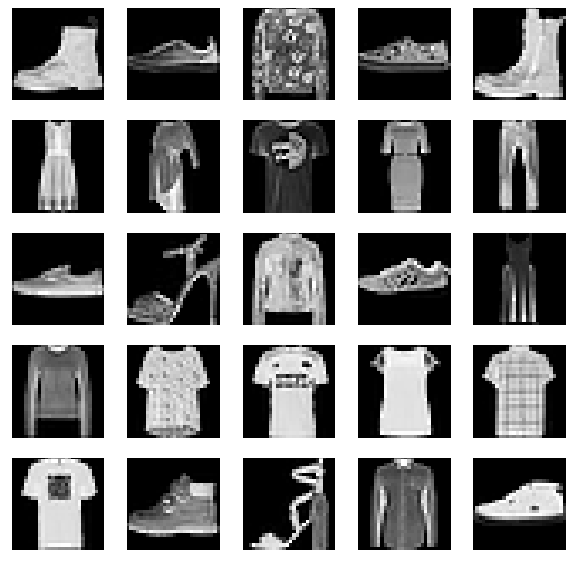

In [40]:
plt.figure(figsize=(10, 10))
for i in range(25):
  plt.subplot(5, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_train[np.random.randint(x_train.shape[0])], cmap='gray')

In [41]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
dataset

<PrefetchDataset shapes: (32, 28, 28), types: tf.float64>

In [42]:
# build the generator 
num_features = 100
generator = keras.models.Sequential([
  keras.layers.Dense(7 * 7 * 128, 'relu', input_shape=[num_features]),
  keras.layers.Reshape([7, 7, 128]),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(64, (5, 5), (2, 2), padding='same', activation='selu'),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(1, (5, 5), (2, 2), padding='same', activation='tanh')
])

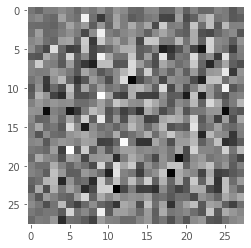

In [43]:
input_noise = tf.random.normal(shape=[1, num_features])
generated_image = generator(input_noise, training=False)
plt.rcParams["axes.grid"] = False
plt.imshow(generated_image.numpy().reshape(28, 28), cmap='gray')

In [44]:
# build the discriminator
discriminator = keras.models.Sequential([
  keras.layers.Conv2D(64, (5, 5), (2, 2), padding='same', input_shape=[28, 28, 1]),
  keras.layers.LeakyReLU(0.2),
  keras.layers.Dropout(0.3),
  keras.layers.Conv2D(128, (5, 5), (2, 2), padding='same'),
  keras.layers.LeakyReLU(0.2),
  keras.layers.Dropout(0.3),
  keras.layers.Flatten(),
  keras.layers.Dense(1, activation='sigmoid')
])

In [45]:
# print(generated_image)
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.50153303]], shape=(1, 1), dtype=float32)


In [46]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [47]:
seed = tf.random.normal(shape=[batch_size, num_features])

In [48]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
  generator, discriminator = gan.layers
  for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch + 1}/{epochs}")
    for X_batch in dataset:
      noise = tf.random.normal(shape=[batch_size, num_features])
      generated_images = generator(noise)
      X_batch = tf.keras.backend.cast(X_batch, dtype=tf.float32)
      X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
      # print(X_fake_and_real.shape)
      y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_fake_and_real, y1)
      discriminator.trainable = False
      y2 = tf.constant([[1.]] * batch_size)
      gan.train_on_batch(noise, y2)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch, seed)
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [49]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [50]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1

In [51]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(batch_size).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

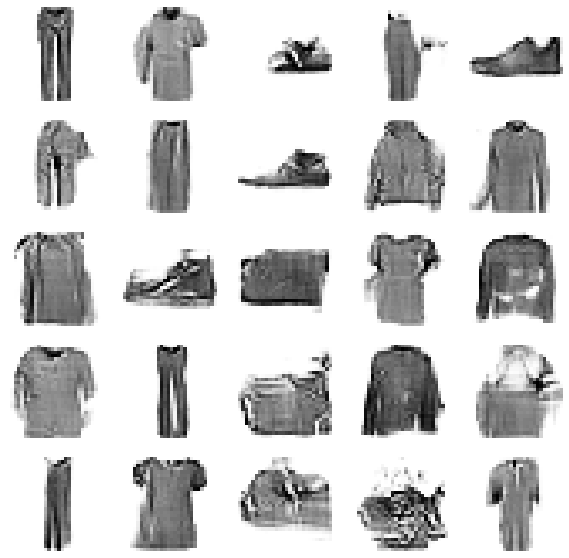

In [52]:
train_dcgan(gan, dataset, batch_size, num_features, epochs=50)

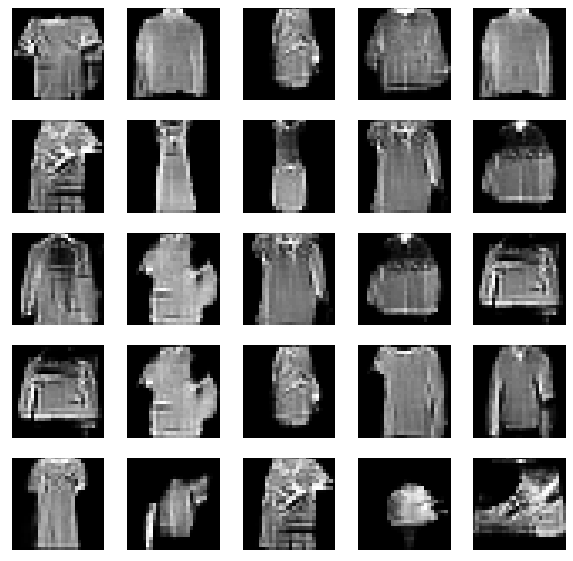

In [56]:
input_noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(input_noise)
plt.figure(figsize=(10, 10))
for i in range(25):
  plt.subplot(5, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(generated_images[np.random.randint(generated_images.shape[0])].numpy().reshape(28, 28), cmap='gray')

In [ ]:
|